# Imports and Supportive Functions

In [1]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# function to call roc curve
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(y_true, y_prob, title='ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [3]:
#Load Dataset
df=pd.read_csv('./water_potability.csv')
x = df.drop('Potability', axis=1).to_numpy()
y = df['Potability'].to_numpy()

In [4]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000
mean,7.088510,195.959995,21918.672232,7.137539,333.249033,426.524220,14.366153,66.405057,3.970090,0.404086
std,1.572453,32.662271,8648.769259,1.584461,41.232106,80.761753,3.321974,16.087090,0.779951,0.490837
min,0.230000,73.490000,320.940000,1.390000,129.000000,201.620000,2.200000,8.580000,1.450000,0.000000
25%,6.090000,176.735000,15615.665000,6.150000,307.630000,366.680000,12.130000,55.955000,3.440000,0.000000
50%,7.030000,197.190000,20933.510000,7.150000,332.230000,423.420000,14.330000,66.540000,3.970000,0.000000
75%,8.050000,216.465000,27195.355000,8.110000,359.400000,482.525000,16.690000,77.310000,4.515000,1.000000
max,14.000000,317.340000,56488.670000,13.130000,481.030000,753.340000,27.010000,124.000000,6.490000,1.000000


In [5]:
#Create Profile Report
 
#Importing package
import pandas_profiling as pp
from IPython.display import IFrame

# Perform Exploratory Data Analysis using pandas-profiling
water_potabilityReport = pp.ProfileReport(df)
water_potabilityReport.to_file('water_potabilityReport.html')
display(IFrame('WaterPotablityReportFP-lbfgs.html', width=900, height=350))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
from sklearn.ensemble import IsolationForest

# The prediction returns 1 if sample point is inlier. If outlier prediction returns -1
clf_all_features = IsolationForest(random_state=100)
clf_all_features.fit(x)

#Predict if a particular sample is an outlier using all features for higher dimensional data set.
y_pred = clf_all_features.predict(x)
y_pred2 =np.array(list(map(lambda x: x == 1, y_pred)))

# Exclude suggested outlier samples for improvement of prediction power/score
x_mod = x[y_pred2, ]
y_mod = y[y_pred2, ]

#Size of Datasets
print('Original Train Dataset Size : {}'.format(len(x)))
print('New Train Dataset Size      : {}'.format(len(x_mod)))

Original Train Dataset Size : 2007
New Train Dataset Size      : 1859


In [7]:
# Create Train and Test Datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_mod, y_mod, test_size=0.20,stratify=y_mod,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.transform(x_test)

x_2 = sc.transform(x)

In [8]:
#Construct some pipelines 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipelines =[]

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(solver='lbfgs',class_weight='balanced',
                                               random_state=100))])
pipelines.insert(0,pipe_logreg)
# Create Pipeline for Gaussian Naive Bayes
pipe_gnb = Pipeline([
    ('scl', StandardScaler()),
    ('clf', GaussianNB())
])
pipelines.insert(1, pipe_gnb) 
#Set grid search params 

modelparas =[]

param_gridlogreg = {'clf__C': [0.1, 1, 5, 20], 
                    'clf__penalty': ['l1','none'],'clf__max_iter': [90,150,2000]}
modelparas.insert(0,param_gridlogreg)
modelparas.insert(1,{})


In [9]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train2, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()

Logistical Regression - Learning Curve


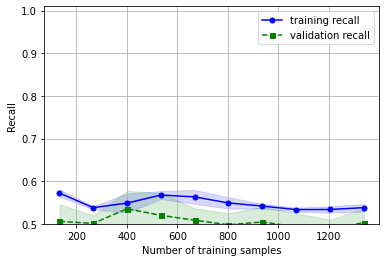

GNB Learning Curve


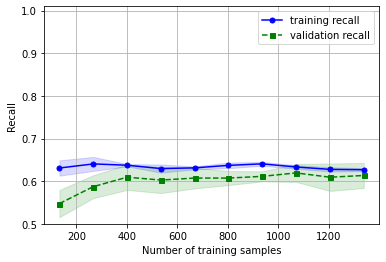

In [10]:
#Plot Learning Curve
print('Logistical Regression - Learning Curve')
plot_learning_curves(pipe_logreg)
print('GNB Learning Curve')
plot_learning_curves(pipe_gnb)

In [11]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RepeatedKFold

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train2, y_train)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test2)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Validation Statistics
    target_names=['0','1']
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
        
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 


Optimized Model

Model Name: LogisticRegression(class_weight='balanced', random_state=100)

Best Parameters: {'clf__C': 0.1, 'clf__max_iter': 90, 'clf__penalty': 'none'}

 [[121 104]
 [ 74  73]]

               precision    recall  f1-score   support

           0       0.62      0.54      0.58       225
           1       0.41      0.50      0.45       147

    accuracy                           0.52       372
   macro avg       0.52      0.52      0.51       372
weighted avg       0.54      0.52      0.53       372

ROC Curve


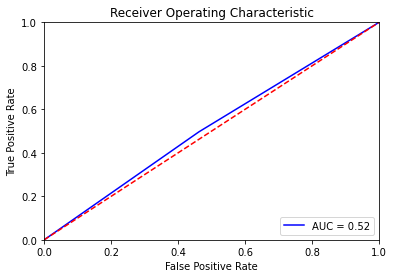


Optimized Model

Model Name: GaussianNB()

Best Parameters: {}

 [[199  26]
 [119  28]]

               precision    recall  f1-score   support

           0       0.63      0.88      0.73       225
           1       0.52      0.19      0.28       147

    accuracy                           0.61       372
   macro avg       0.57      0.54      0.51       372
weighted avg       0.58      0.61      0.55       372

ROC Curve


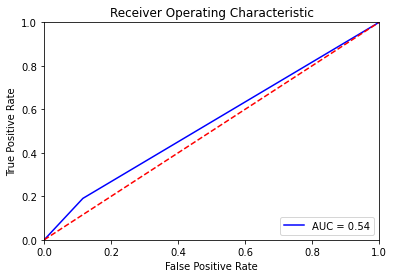

In [12]:
# Loop through the pipelines and model parameters
for pipeline, modelpara in zip(pipelines, modelparas):
    Gridsearch_cv(pipeline, modelpara)


In [13]:
# Make Ensamble MOdels
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
ensemble_models = []
para = []
# Create pipelines for different models
pipeline_adaboost = Pipeline([
    ('scl', StandardScaler()),
    ('clf', AdaBoostClassifier(random_state=100))
])
ensemble_models.insert(0,pipeline_adaboost)

pipeline_randomforest = Pipeline([
    ('scl', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=100))
])
ensemble_models.insert(1,pipeline_randomforest)

pipeline_xgboost = Pipeline([
    ('scl', StandardScaler()),
    ('clf', XGBClassifier(random_state=100))
])
ensemble_models.insert(2,pipeline_xgboost)
param_grid_adaboost = {
    'clf__n_estimators': [50, 100, 150],
    'clf__learning_rate': [0.01, 0.1, 1.0]
}
para.insert(0,param_grid_adaboost)

param_grid_randomforest = {
    'clf__n_estimators': [50, 100, 150],
    'clf__max_depth': [None, 10, 20]
}
para.insert(1,param_grid_randomforest)

param_grid_xgboost = {
    'clf__n_estimators': [50, 100, 150],
    'clf__max_depth': [3, 4, 5],
    'clf__learning_rate': [0.01, 0.1, 0.2]
}
para.insert(2,param_grid_xgboost)



Optimized Model

Model Name: AdaBoostClassifier(random_state=100)

Best Parameters: {'clf__learning_rate': 0.1, 'clf__n_estimators': 50}

 [[222   3]
 [140   7]]

               precision    recall  f1-score   support

           0       0.61      0.99      0.76       225
           1       0.70      0.05      0.09       147

    accuracy                           0.62       372
   macro avg       0.66      0.52      0.42       372
weighted avg       0.65      0.62      0.49       372

ROC Curve


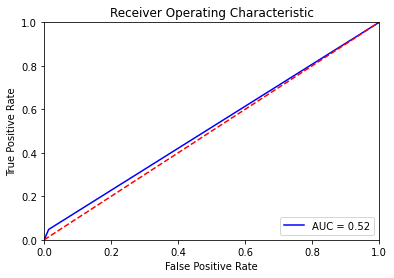


Optimized Model

Model Name: RandomForestClassifier(random_state=100)

Best Parameters: {'clf__max_depth': 20, 'clf__n_estimators': 150}

 [[195  30]
 [ 93  54]]

               precision    recall  f1-score   support

           0       0.68      0.87      0.76       225
           1       0.64      0.37      0.47       147

    accuracy                           0.67       372
   macro avg       0.66      0.62      0.61       372
weighted avg       0.66      0.67      0.64       372

ROC Curve


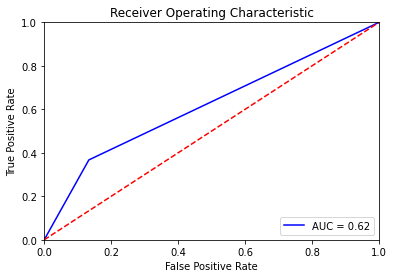


Optimized Model

Model Name: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=100, ...)

Best Parameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 50}

 [[202  23]
 [ 99  48]]

               precision    recall  f1-score   support

           0       0.67      0.90      0.77  

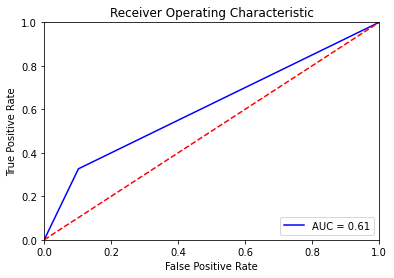

In [14]:
for pipeline, modelpara in zip(ensemble_models, para):
    Gridsearch_cv(pipeline, modelpara)

              precision    recall  f1-score   support

           0       0.63      0.95      0.76       225
           1       0.68      0.16      0.25       147

    accuracy                           0.64       372
   macro avg       0.65      0.55      0.51       372
weighted avg       0.65      0.64      0.56       372



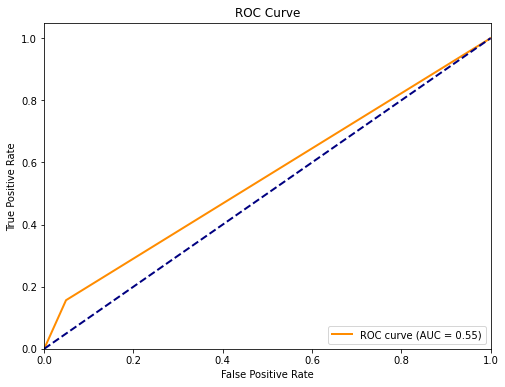

In [15]:
#voting model
nb = GaussianNB()
rf = RandomForestClassifier(max_depth= 5, n_estimators = 150, random_state=100)
from sklearn.ensemble import VotingClassifier
# Create the voting classifier
voting_classifier = VotingClassifier(estimators=[('rf', rf), ('nb', nb)], voting='soft')

# Train the voting classifier
voting_classifier.fit(x_train2, y_train)

# Make predictions
y_pred = voting_classifier.predict(x_test2)

# Calculate accuracy
rpt = classification_report(y_test, y_pred)
print(rpt)
plot_roc_curve(y_test, y_pred, title='ROC Curve')

              precision    recall  f1-score   support

           0       0.64      0.96      0.77       225
           1       0.76      0.17      0.28       147

    accuracy                           0.65       372
   macro avg       0.70      0.57      0.52       372
weighted avg       0.69      0.65      0.58       372



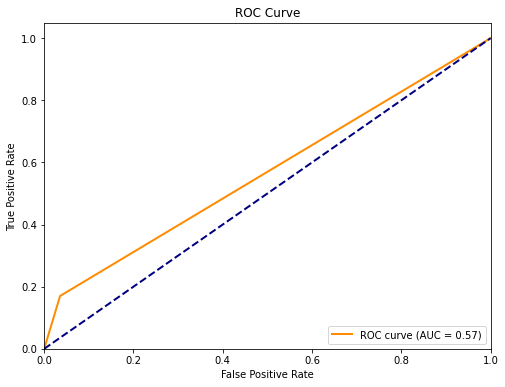

In [17]:
base_models = [
    GaussianNB(), RandomForestClassifier(max_depth= 5, n_estimators = 150, random_state=100),XGBClassifier(random_state=100)
]

predictions = np.zeros((x_test2.shape[0], len(base_models)))
meta_model = LogisticRegression()

# Create an array to hold the predictions of base models on the test set
predictions = np.zeros((x_test.shape[0], len(base_models)))

# Train the base models and make predictions on the test set
for i, model in enumerate(base_models):
    model.fit(x_train2, y_train)
    y_pred = model.predict(x_test2)
    predictions[:, i] = y_pred

# Train the meta-model on the predictions of base models
meta_model.fit(predictions, y_test)

# Make final predictions using the stacking model
final_predictions = meta_model.predict(predictions)

# Evaluate the stacking model
print(classification_report(y_test, final_predictions))
plot_roc_curve(y_test,final_predictions,title='ROC Curve')

# Random forest is giving best accuracy with better prediction rate.